In [1]:
from __future__ import print_function
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno
print('sa')

sa


In [2]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u OCR basic
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [3]:
def select_roi(image_orig, image_bin):
    '''
    Funkcija kao u vežbi 2, iscrtava pravougaonike na originalnoj slici, pronalazi sortiran niz regiona sa slike,
    i dodatno treba da sačuva rastojanja između susednih regiona.
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = []  # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    x0, y0, w0, h0 = cv2.boundingRect(contours[0])  # koordinate i velicina granicnog pravougaonika

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        # CIFRE, x, y, +
        if h > 2 and w > 1 and h < 80 and w < 60 :
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y + h + 1, x:x + w + 1];
            regions_dic[x] = resize_region(region)
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
            #         # minus

    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()

    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

In [4]:
def display_result(outputs, alphabet):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        result += alphabet[winner(output)]
    return result


def display_result1(outputs, alphabet):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    # w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:, :]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        # if (k_means.labels_[idx] == w_space_group):
        # result += ' '
        result += alphabet[winner(output)]
    return result


In [5]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(16, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False) 
      
    return ann

Broj prepoznatih regiona: 16


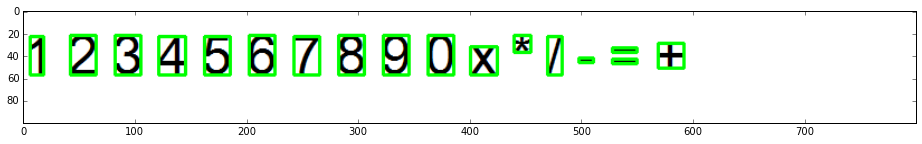

In [6]:
image_color = load_image('images/novo.png')

image_test_obucavanje = invert(image_bin(image_gray(image_color)))
# img = image_bin(image_gray(image_color))
selected_test_obucavanje, letters_obucavanje = select_roi(image_color.copy(), image_test_obucavanje)

# selected_regions, letters = select_roi(image_color, img)
display_image(selected_test_obucavanje)
print ('Broj prepoznatih regiona:', len(letters_obucavanje))

In [7]:
alphabet = ['1','2','3','4','5','6','7','8','9','0','x','*','/','-','=','+']
inputs = prepare_for_ann(letters_obucavanje)
outputs = convert_output(alphabet)
ann = create_ann()


In [8]:
ann = train_ann(ann, inputs, outputs)

Broj prepoznatih regiona: 7


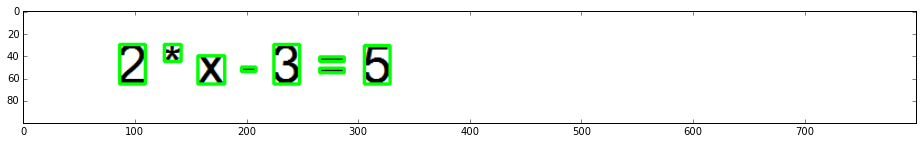

In [9]:
image_color = load_image('images/d.png')

image_test_obucavanje = invert(image_bin(image_gray(image_color)))
selected_test_obucavanje, letters_obucavanje = select_roi(image_color.copy(), image_test_obucavanje)

display_image(selected_test_obucavanje)
print ('Broj prepoznatih regiona:', len(letters_obucavanje))

Broj prepoznatih regiona: 7


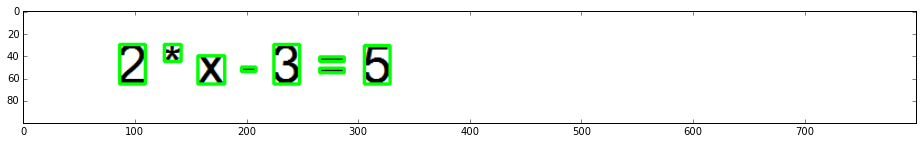

In [10]:
selected_regions, letters = select_roi(image_color.copy(), image_test_obucavanje)
display_image(selected_regions)
print('Broj prepoznatih regiona:', len(letters))

In [11]:
inputs = prepare_for_ann(letters)
results = ann.predict(np.array(inputs, np.float32))
print(display_result1(results, alphabet))

2*x-3=5


In [12]:
jednacina = display_result1(results, alphabet)

jednacina = ''.join(jednacina.split())
jednacina = unicode(jednacina)

if "x" in jednacina:
        jednacina = jednacina.replace("x", "X")
        
print(jednacina)

import re
def linearna (equ):
    fixed = ""
    
    if "*" in equ:
        if (equ.split()[0][0] == "-"): # da li je minus na pocetku
            if "-" in equ.split("=",1)[1]: # da li je minus posle =
                fixed = equ[1:] #skida minus s pocetka
                fixed = fixed.split("=",1)[0] # uzima sve pre = 
                if "-" not in fixed: 
                    match = re.match(r"(\-\d+)\*X\+(\d+)=(\-\d+)", equ)
                else:
                    match = re.match(r"(\-\d+)\*X(\-\d+)=(\-\d+)", equ)
            else:
                fixed = equ[1:]
                fixed = fixed.split("=",1)[0] 
                if "-" not in fixed: 
                    match = re.match(r"(\-\d+)\*X\+(\d+)=(\d+)", equ)
                else:
                    match = re.match(r"(\-\d+)\*X(\-\d+)=(\d+)", equ)
        else:
            if "-" in equ.split("=",1)[1]:
                fixed = equ[1:]
                fixed = fixed.split("=",1)[0]
                if "-" not in fixed: 
                    match = re.match(r"(\d+)\*X\+(\d+)=(\-\d+)", equ)
                else: 
                    match = re.match(r"(\d+)\*X(\-\d+)=(\-\d+)", equ)
            else:
                fixed = equ[1:]
                fixed = fixed.split("=",1)[0]
                if "-" not in fixed: 
                    match = re.match(r"(\d+)\*X\+(\d+)=(\d+)", equ)
                else: 
                    match = re.match(r"(\d+)\*X(\-\d+)=(\d+)", equ)
    else:
        if (equ.split()[0][0] == "-"):
            if "-" in equ.split("=",1)[1]:
                fixed = equ[1:]
                fixed = fixed.split("=",1)[0]
                if "-" not in fixed: 
                    match = re.match(r"(\-\d+)X\+(\d+)=(\-\d+)", equ)
                else:
                    match = re.match(r"(\-\d+)X(\-\d+)=(\-\d+)", equ)
            else:
                fixed = equ[1:]
                fixed = fixed.split("=",1)[0]
                if "-" not in fixed: 
                    match = re.match(r"(\-\d+)X\+(\d+)=(\d+)", equ)
                else:
                    match = re.match(r"(\-\d+)X(\-\d+)=(\d+)", equ)
        else:
            if "-" in equ.split("=",1)[1]:
                fixed = equ[1:]
                fixed = fixed.split("=",1)[0]
                if "-" not in fixed: 
                    match = re.match(r"(\d+)X\+(\d+)=(\-\d+)", equ)
                else: 
                    match = re.match(r"(\d+)X(\-\d+)=(\-\d+)", equ)
            else:
                fixed = equ[1:]
                fixed = fixed.split("=",1)[0]
                if "-" not in fixed: 
                    match = re.match(r"(\d+)X\+(\d+)=(\d+)", equ)
                else: 
                    match = re.match(r"(\d+)X(\-\d+)=(\d+)", equ)

    m, c, y = match.groups()
    m, c, y = float(m), float(c), float(y) # Convert from strings to numbers
    print(m,c,y)
    X = (y-c)/m
    print ("x = %f" % X)
    
def kvadratna(j):
    lista = []

    for index, char in enumerate(j):
        s = char.decode('ascii', 'ignore').encode('ascii')
        if unicode(s,'utf-8').isnumeric():
            if(j[index-1] == "x" or j[index-1] == "X"):
                continue
            else:
                if j[index-1] == "-" or j[index-1] == "—":
                    a = float(char)
                    a = -a
                    lista.append(a)
                elif(j[index-1] == "="):
                    continue
                else:
                    lista.append(float(char))
                
    
    import cmath

    if j.split()[0][0] == "x" or j.split()[0][0] == "X":
        a = 1
        b= lista[0]
        c=lista[1]
    else:
        a = lista[0] 
        b= lista[1]
        c=lista[2]

    delta = (b**2) - (4*a*c)
    solution1 = (-b-cmath.sqrt(delta))/(2*a)
    solution2 = (-b+cmath.sqrt(delta))/(2*a)

    print('Resenja su {0} i {1}'.format(solution1,solution2))
    



if(jednacina.count('X') == 2):
    kvadratna(jednacina)
else:
    linearna(jednacina)

2*X-3=5
2.0 -3.0 5.0
x = 4.000000
